In [7]:
import pandas as pd
import numpy as np
import json
import re
from llms import gemini
from llms import chatGPT
from sklearn.metrics.pairwise import cosine_similarity

x_chat = chatGPT()
x_gemini = gemini()

def load_codes():
    return pd.read_csv("../input/soc_codes/soc_codes.csv", index_col=0)

def check_onet_title_match(df):
    codes = pd.read_csv("../input/soc_codes/all_soc_codes.csv",index_col=0)
    df['similar_title_groups'] = df.example_job_title.apply(
        lambda x: [title for y in x.split(" and ") for title in codes[codes["Title"].str.contains(re.escape(y), na=False)]["Title"].values]
    )
    df['title_overlap'] = df.apply(lambda x: x["Broad Group"] in x.similar_title_groups, axis=1)
    df_empty = df[~df.title_overlap]
    print(len(df_empty))
    df = df[df.title_overlap]
    df_empty.loc[:, "title_groups"] = df_empty.Job_similarity_titles.apply( lambda x: [y[1] for y in json.loads(x)] if not pd.isnull(x) else np.nan )
    df_empty.loc[:, "similar_title_groups"] = df_empty.Job_similarity_titles.apply( lambda x: [y[1][1][:6] + "0" for y in json.loads(x)] if not pd.isnull(x) else np.nan )
    df = pd.concat([df,df_empty],axis=0)
    df['title_overlap'] = df.apply(lambda x: x["Broad Group"] in x.similar_title_groups, axis=1)
    print(f"The number of titles that did not overlap {len(df[~df.title_overlap])}")
    df = df[df.title_overlap]
    return df

def get_ONET(task_sim, title_sim, conf_interval=True):
    onet_df = pd.read_csv("../output/results v3/onet_df.csv")
    onet_df = onet_df[(onet_df.task_similarity > task_sim) & (onet_df.job_title_similarity > title_sim)]
    onet_df = onet_df[onet_df.situation_conf_interval > conf_interval].reset_index(drop=True)
    onet_df = compute_ONET_weights(onet_df)
    print(f"{len(onet_df)} tasks with task similarity > {task_sim} and title similarity > {title_sim}")
    return onet_df

def compute_ONET_weights(onet_df):
    onet_weights = onet_df.groupby("organization_name")["onet_title"].count().apply(lambda x: 1/x).reset_index().rename({"onet_title": "onet_weight"}, axis=1)
    onet_df = onet_df.merge(onet_weights, on="organization_name")
    return onet_df

def get_ONET_titles(df):
    onet_titles = df.groupby("onet_title").aggregate({"onet_weight": "sum", "Detailed Occupation": "first"})
    onet_titles.onet_weight = onet_titles.onet_weight.round(2)
    onet_titles = onet_titles.reset_index().sort_values(by="onet_weight", ascending=False)
    return onet_titles

def get_startup_generated_LLM_titles(onet_df):
    example_job_titles_df = onet_df.example_job_title.value_counts().apply(lambda x: x/3).reset_index()
    return example_job_titles_df

def print_top_100_ONET_tasks(onet_df):
    top_100_ONETtasks = onet_df['onet_task'].value_counts().reset_index().head(100)
    top_100_tasks.columns = ['Task', 'Frequency']
    for index, row in top_100_tasks.iterrows():
        print(f"Task = {row['Task']}, Frequency = {row['Frequency']}\n")

def get_startup_data():
    startup_df = pd.read_csv("../output/results v3/df_with_examples.csv")
    cols = ['organization name', 'founded date', 'website', 'description_all', 'industries_parsed', 'generated_description', 'parsed_description', 'Tasks/Jobs', 'Industry', 'Customers', 'generated_description_conf_interval', 'parsed_description_conf_interval']
    df = startup_df[cols]
    df = df.merge(onet_df,left_on="organization name",right_on="organization_name")
    df = df.merge(codes,left_on="onet_title",right_on="Title")
    # df = check_onet_title_match(df)
    num_startups = len(startup_df["organization name"].unique())
    num_onet_startups = len(df["organization_name"].unique())
    print(f"{num_onet_startups} startups out of {num_startups} decomposed")
    return df

def get_wage():
    wage_employment = pd.read_csv("../input/wage_employment/wage_employment_bls.csv")
    wage_employment = wage_employment[wage_employment.O_GROUP == "detailed"]
    wage_employment = wage_employment.rename({"OCC_CODE": "Detailed Occupation"}, axis=1)
    wage_employment = wage_employment.replace("#", np.nan).replace("*", np.nan).replace({",": ""}, regex=True)
    wage_employment[["H_MEDIAN", "A_MEDIAN"]] = wage_employment[["H_MEDIAN", "A_MEDIAN"]].astype("float")
    wage_employment["H_MEDIAN"] = wage_employment["H_MEDIAN"].round(0)
    return wage_employment

def get_skills():
    skills_df = pd.read_csv("../input/skills/Skills.csv")
    skills_df = skills_df[skills_df["Scale Name"] == "Importance"]
    skills_df = skills_df.rename(columns={"O*NET-SOC Code": "Detailed Occupation"})
    skills_df["Detailed Occupation"] = skills_df["Detailed Occupation"].replace(r'\.\d{2}', '', regex=True)
    skills_df = skills_df.pivot_table(index=skills_df["Detailed Occupation"], columns='Element Name', values='Data Value', fill_value=0)
    return skills_df

def get_skills_SOC():
    skills_df = pd.read_csv("../input/skills_df_soc_codes.csv", index_col=0)
    return skills_df

def get_wage_skills():
    wage_employment = get_wage()
    skills_df = get_skills_SOC()
    bls_df = skills_df.merge(wage_employment, on="Detailed Occupation", how="inner")
    return bls_df

def BLS_titles(onet_titles, bls_df):
    bls_df = onet_titles.merge(bls_df, on="Detailed Occupation", how="right")
    return bls_df

def BLS(df, bls_df):
    df = df.merge(bls_df, on="Detailed Occupation")
    return df
    
# Example usage
codes = load_codes()
onet_df = get_ONET(task_sim=0.67, title_sim=0.1)
df = get_startup_data()
bls_df = get_wage_skills()
onet_titles = get_ONET_titles(df)
bls_titles = BLS_titles(onet_titles, bls_df)
df = BLS(df, bls_df)
len(df)

3005 tasks with task similarity > 0.67 and title similarity > 0.1
1062 startups out of 2188 decomposed


2594

In [2]:
df.head()

organization name founded date            website  \
0              Pika   2023-01-01           pika.art   
1           Ssemble   2023-02-13        ssemble.com   
2          Brask AI   2023-04-20       www.brask.ai   
3              Pika   2023-01-01           pika.art   
4    Spot Runner AI   2023-01-01  www.spotrunner.ai   

                                     description_all  \
0  Pika is a startup that develops an AI-powered ...   
1  Ssemble is a collaborative online video editor...   
2  Brask is a global AI content company that reim...   
3  Pika is a startup that develops an AI-powered ...   
4  Spot Runner AI is a generative AI media intell...   

                              industries_parsed  \
0  ['Generative AI', 'Graphic Design', 'Video']   
1                     ['SaaS', 'Video Editing']   
2  ['Advertising', 'Content Creators', 'Video']   
3  ['Generative AI', 'Graphic Design', 'Video']   
4                                            []   

                               generated_description  \
0  Pika is an AI-powered platform that transforms...   
1  Ssemble is a collaborative online video editor...   
2  Brask AI offers a suite of AI-powered tools fo...   
3  Pika is an AI-powered platform that transforms...   
4  Spot Runner AI provides a generative AI media ...   

                                  parsed_description  \
0  Tasks/Jobs: Video creation, Video editing, Ima...   
1  Tasks/Jobs: Video editing, Script writing, Noi...   
2  Tasks/Jobs: Video localization, Dubbing, Digit...   
3  Tasks/Jobs: Video creation, Video editing, Ima...   
4  Tasks/Jobs: Content creation, Video editing, M...   

                                          Tasks/Jobs                 Industry  \
0  Video creation, Video editing, Image animation...         Video Production   
1  Video editing, Script writing, Noise removal, ...         Video production   
2  Video localization, Dubbing, Digital double cr...         Content creation   
3  Video creation, Video editing, Image animation...         Video Production   
4  Content creation, Video editing, Media analysi...  Media and Entertainment   

                                           Customers  ...  H_MEDIAN H_PCT75  \
0  Marketers, Content creators, Social media mana...  ...      30.0   45.13   
1                  Video creators, Teams, Businesses  ...      30.0   45.13   
2  Content entrepreneurs, Brands, Agencies, Celeb...  ...      30.0   45.13   
3  Marketers, Content creators, Social media mana...  ...      32.0   48.99   
4    Media companies, Content creators, Broadcasters  ...      32.0   48.99   

  H_PCT90 A_PCT10  A_PCT25 A_MEDIAN A_PCT75 A_PCT90 ANNUAL HOURLY  
0   58.05   34420    44000  61800.0   93870  120740    NaN    NaN  
1   58.05   34420    44000  61800.0   93870  120740    NaN    NaN  
2   58.05   34420    44000  61800.0   93870  120740    NaN    NaN  
3   74.27   38990    48920  66600.0  101910  154480    NaN    NaN  
4   74.27   38990    48920  66600.0  101910  154480    NaN    NaN  

[5 rows x 109 columns]

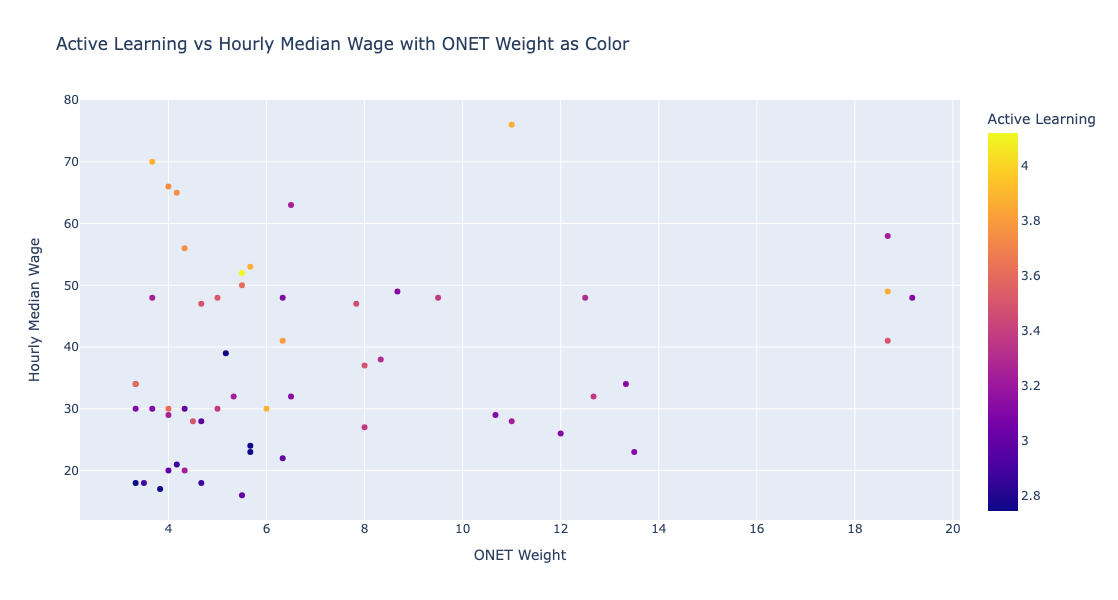

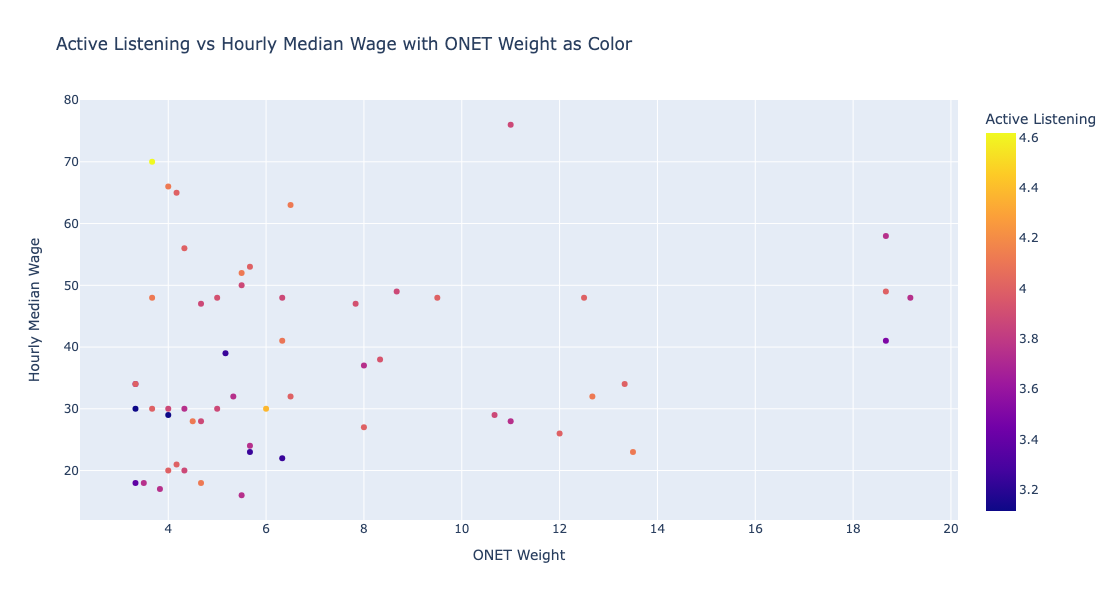

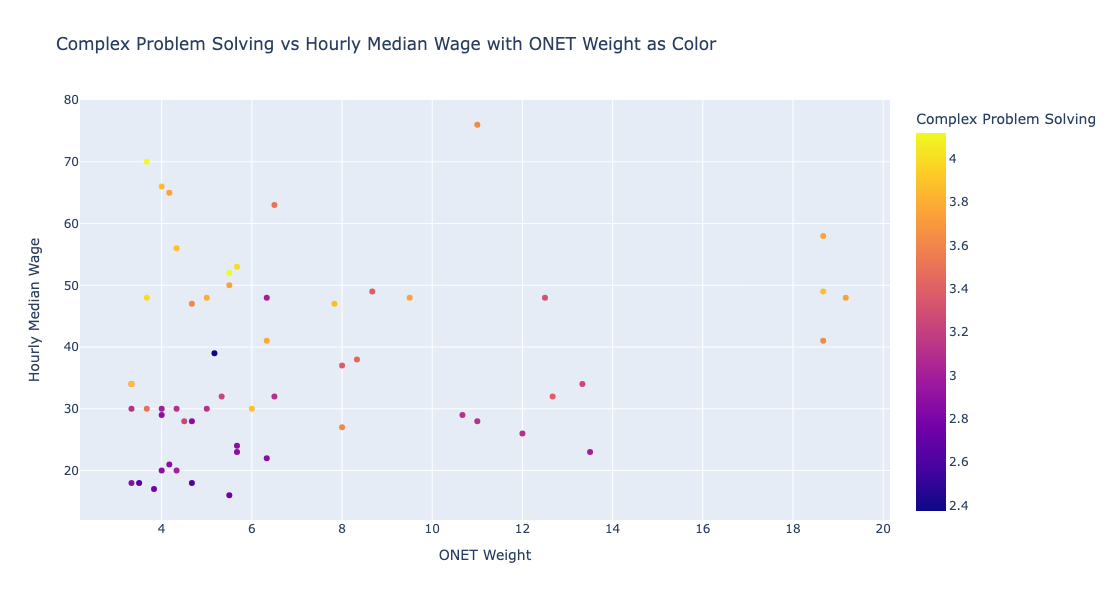

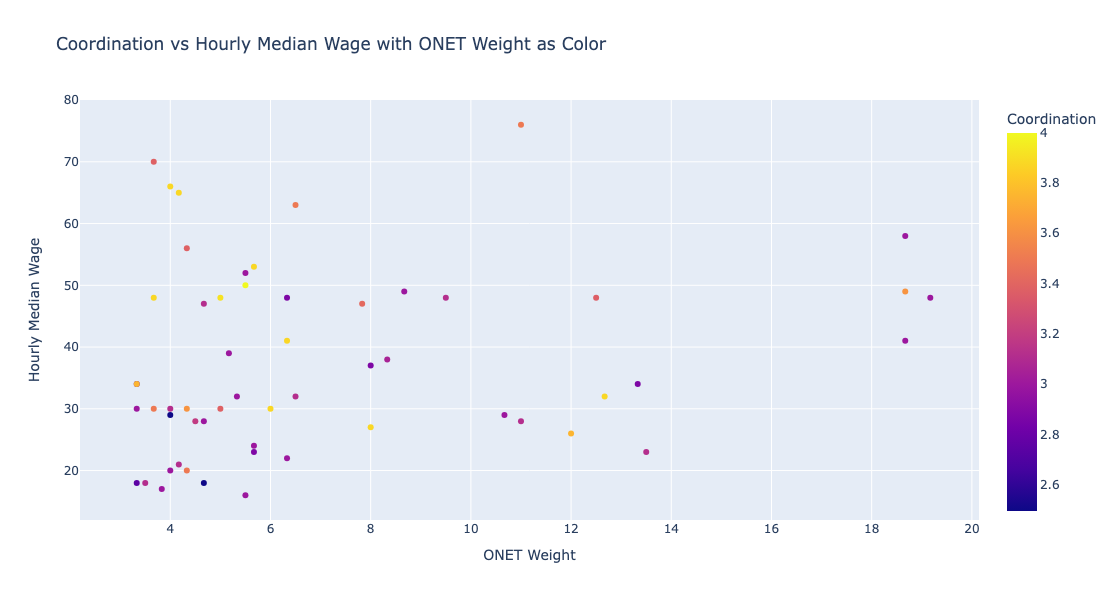

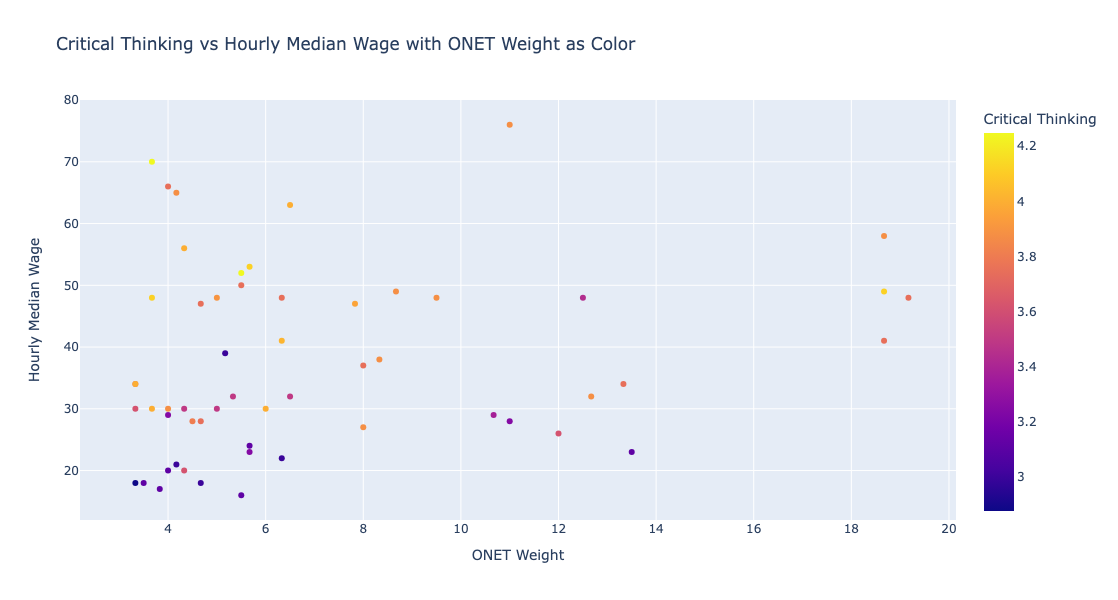

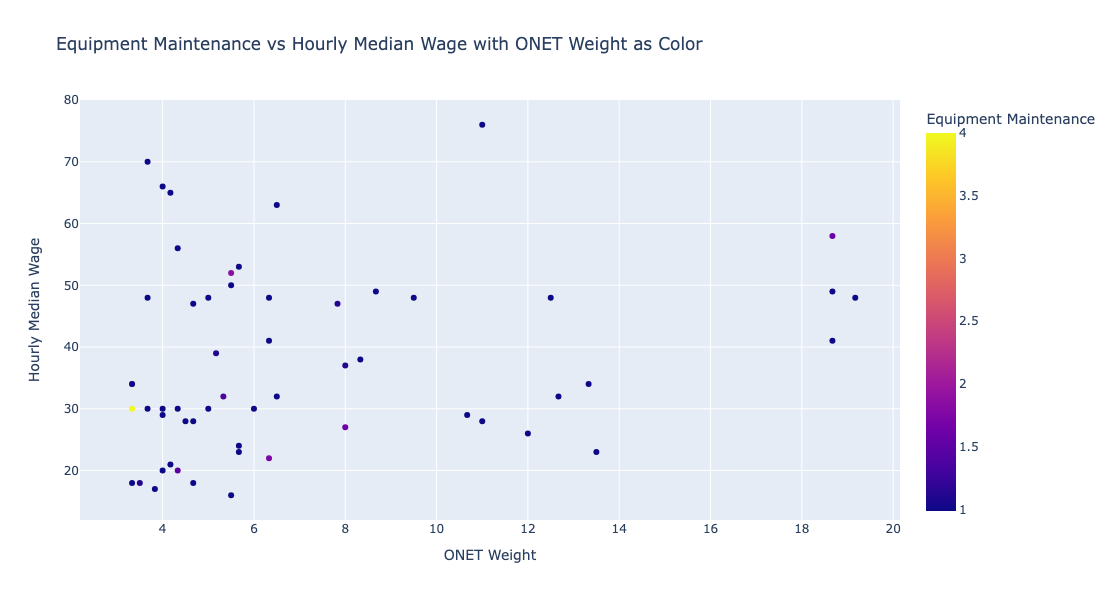

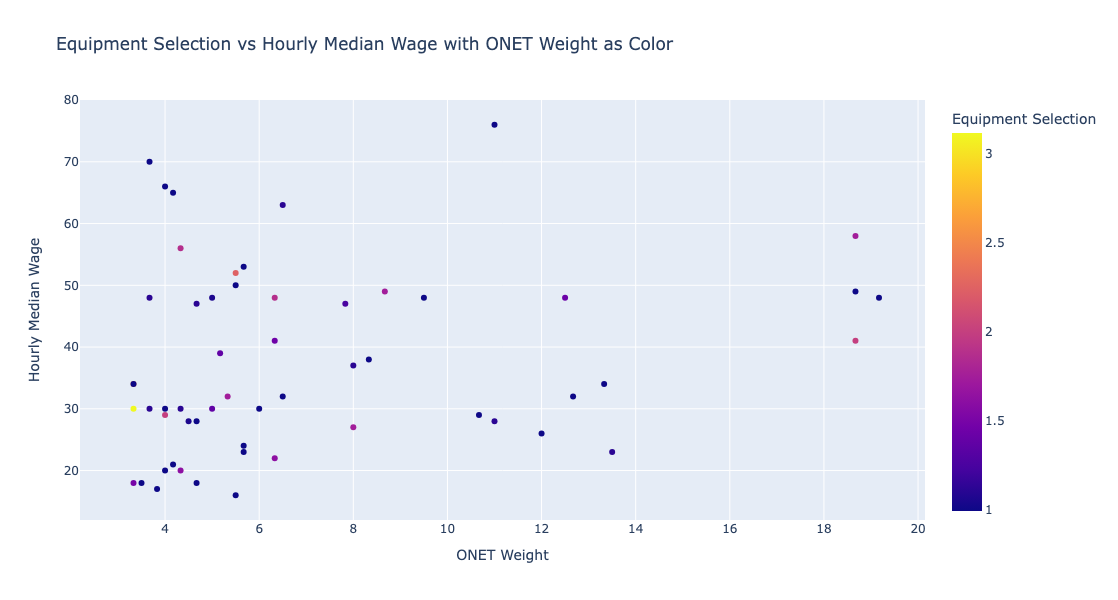

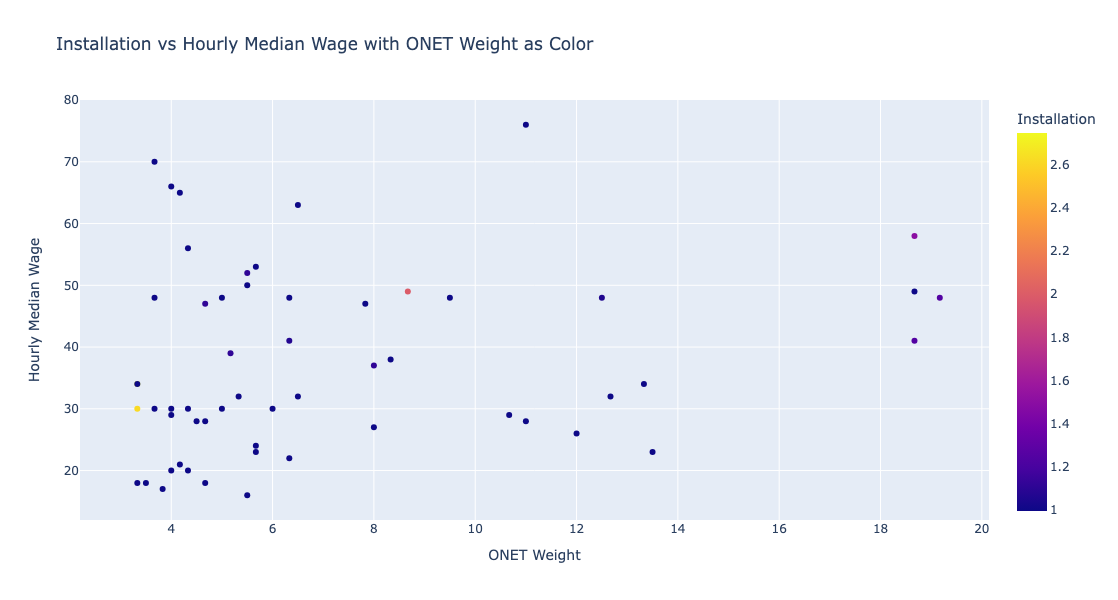

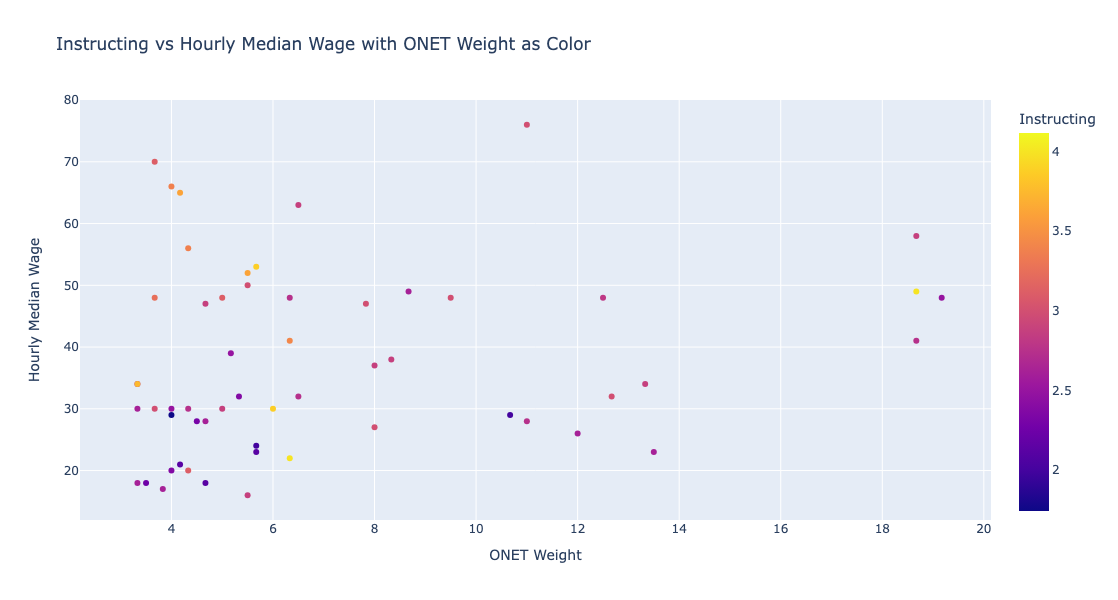

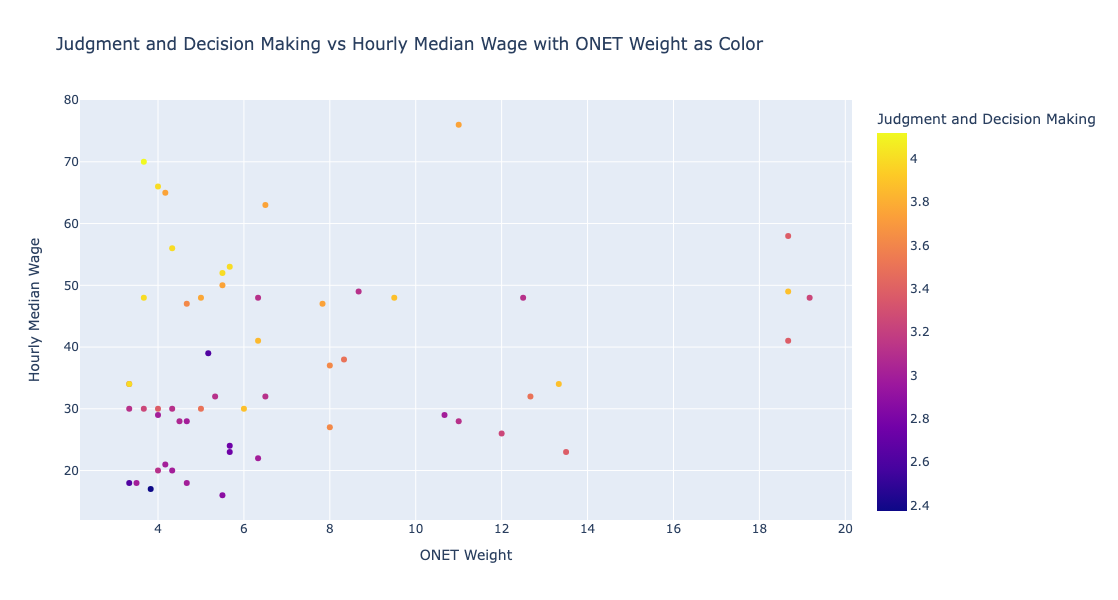

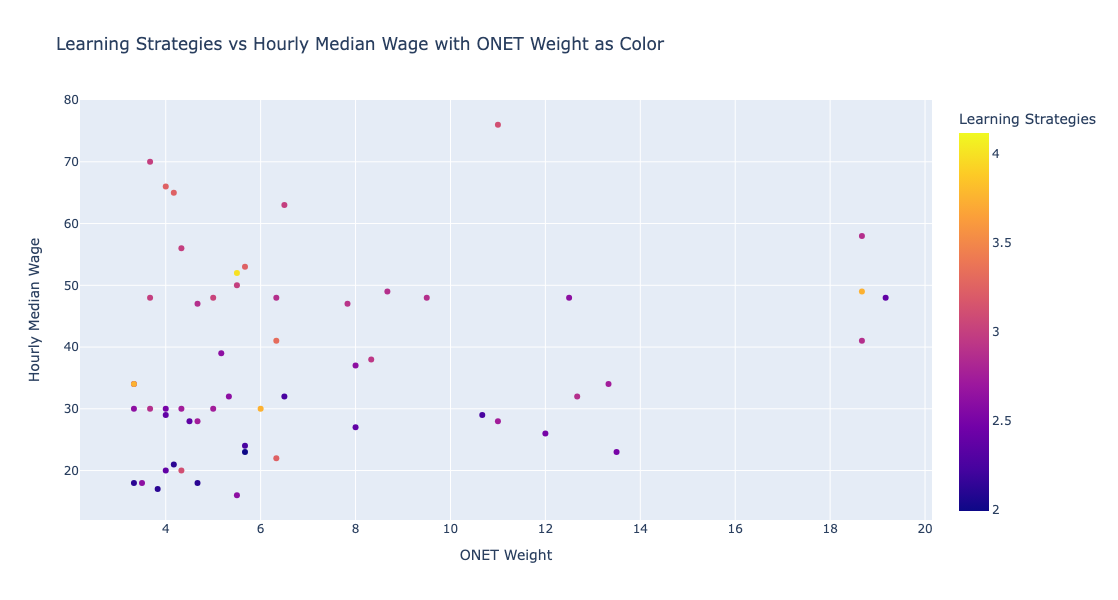

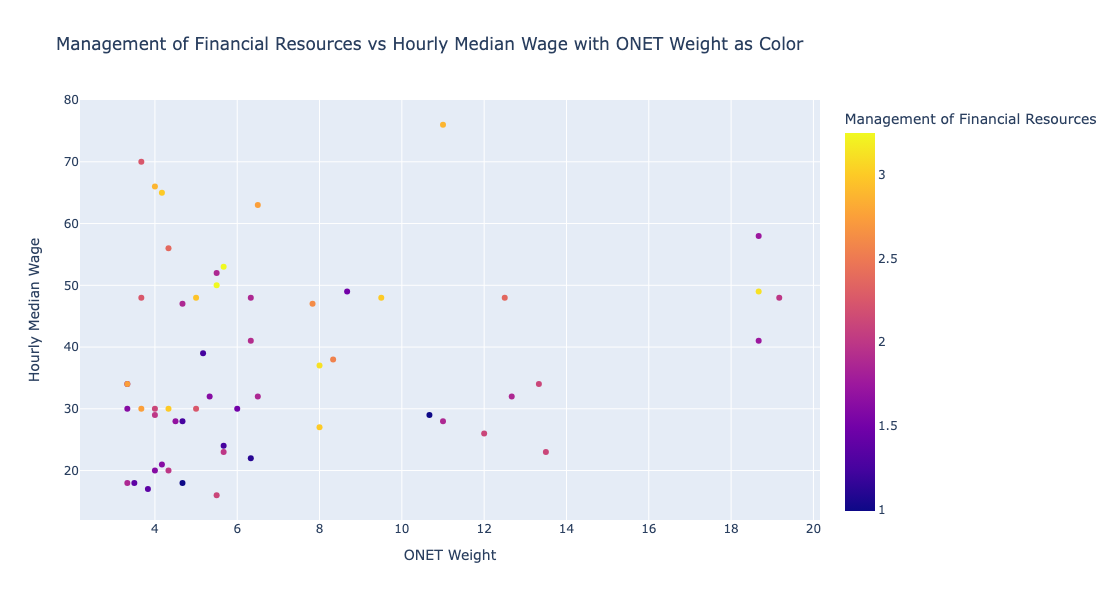

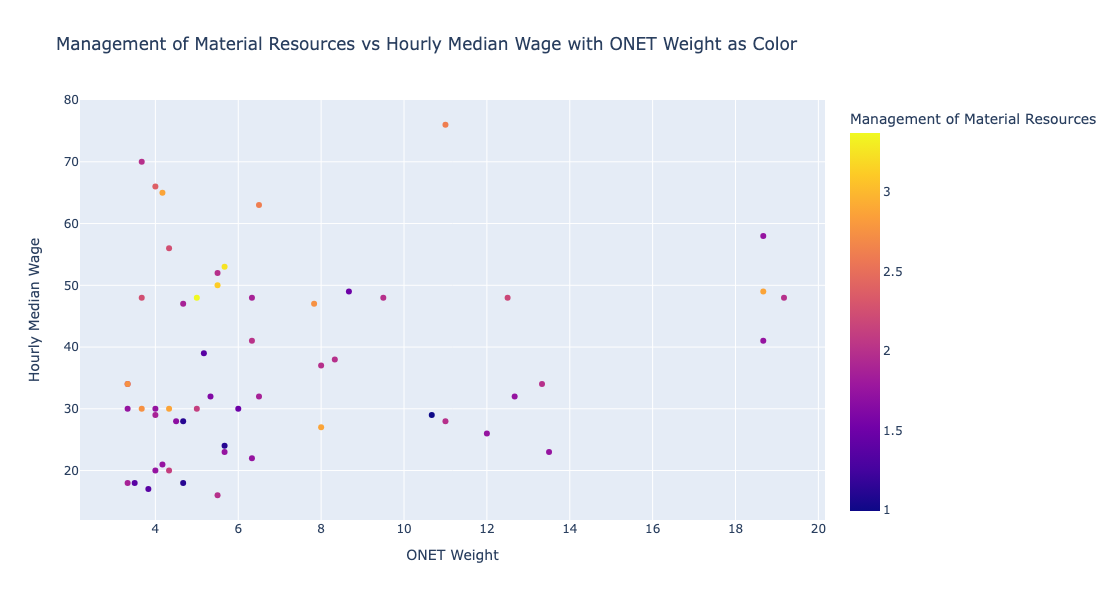

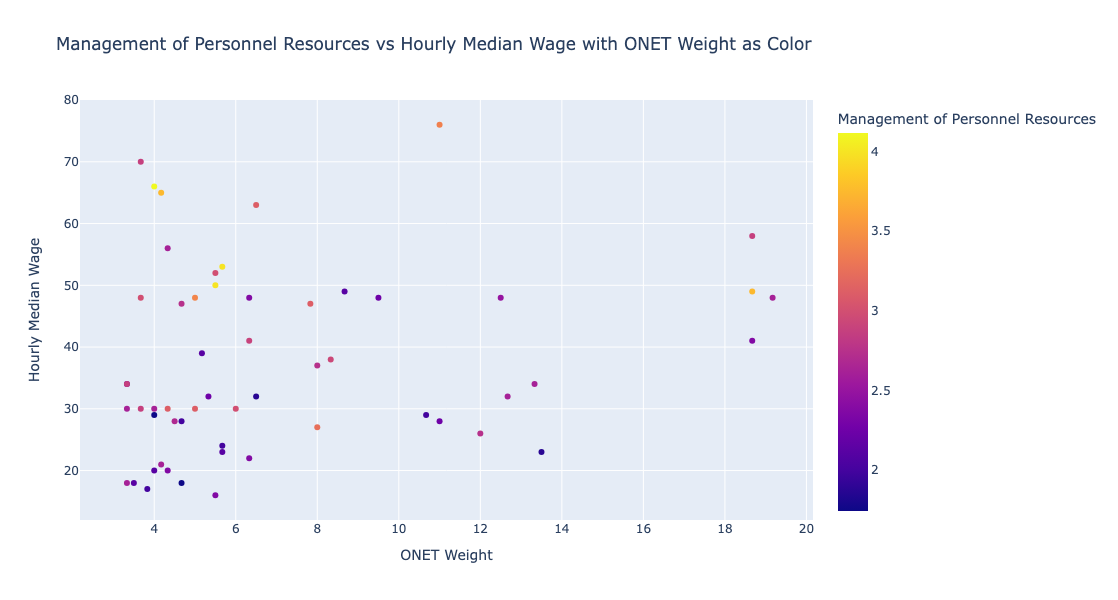

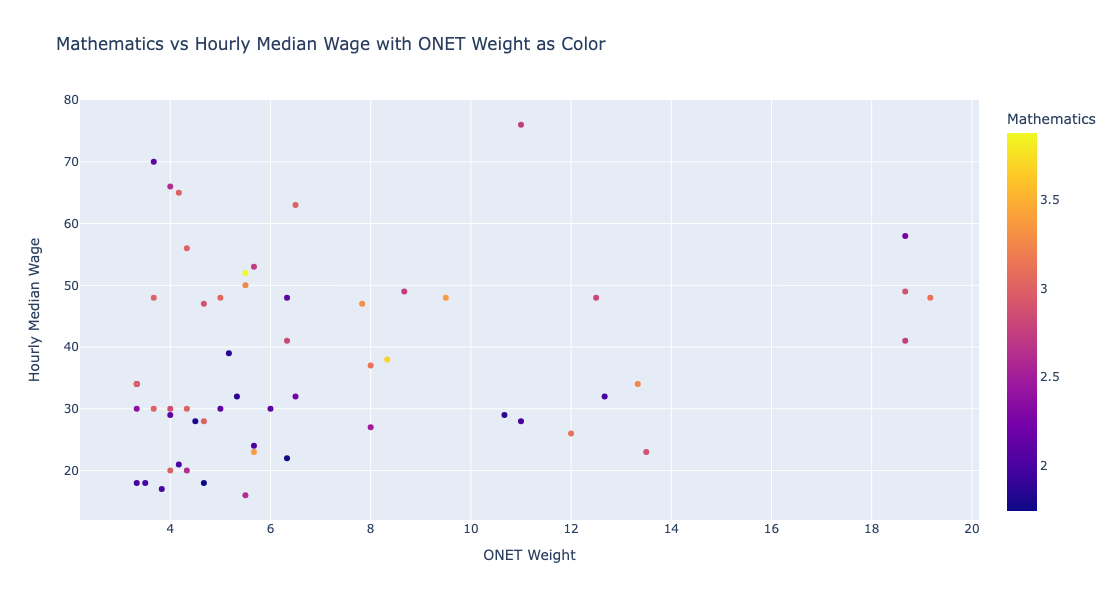

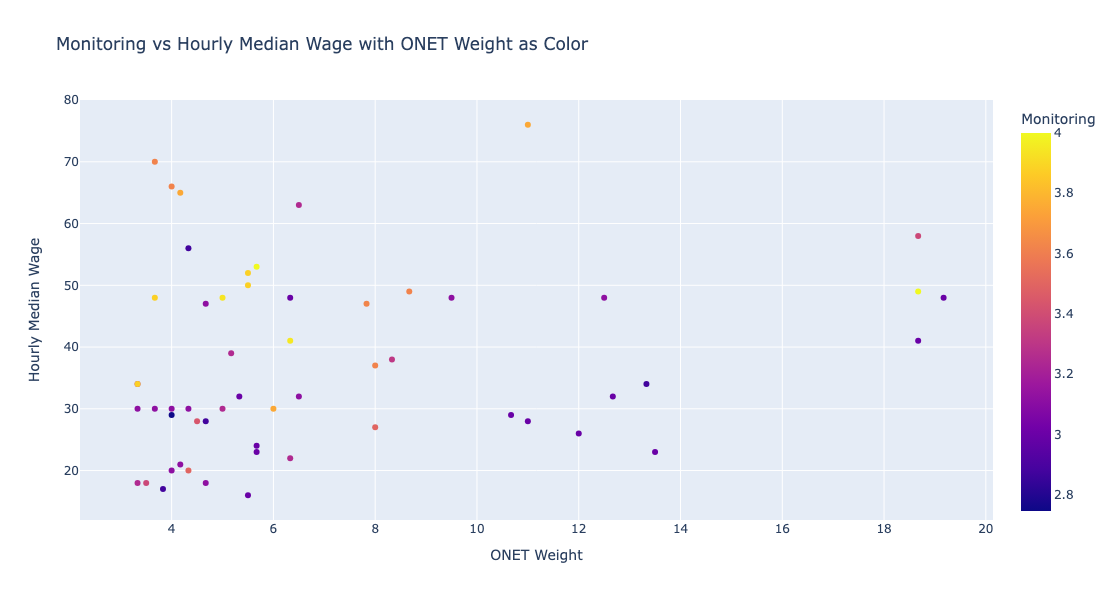

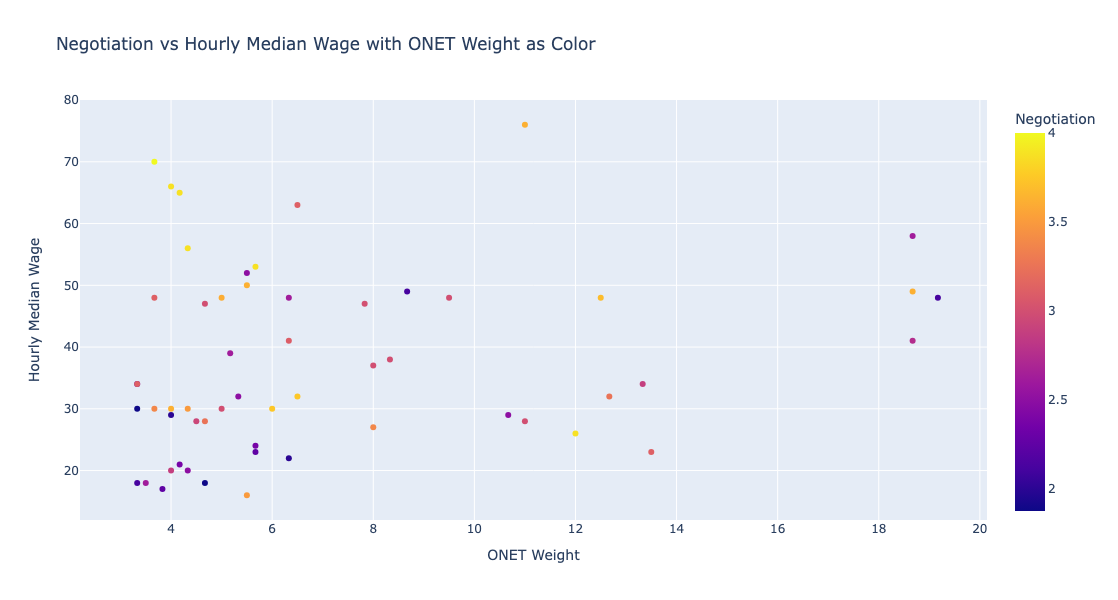

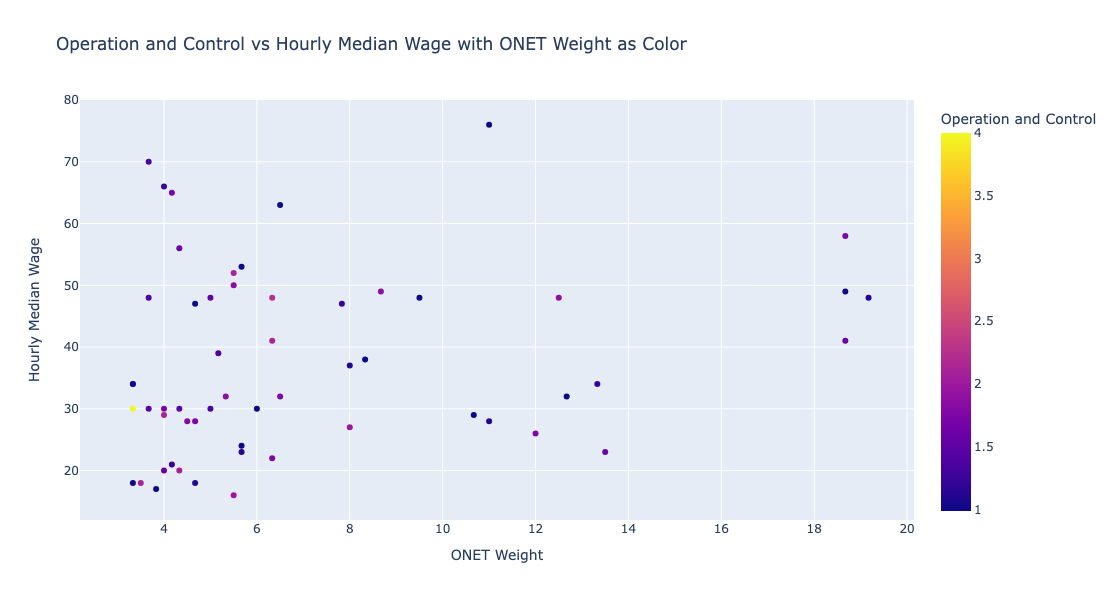

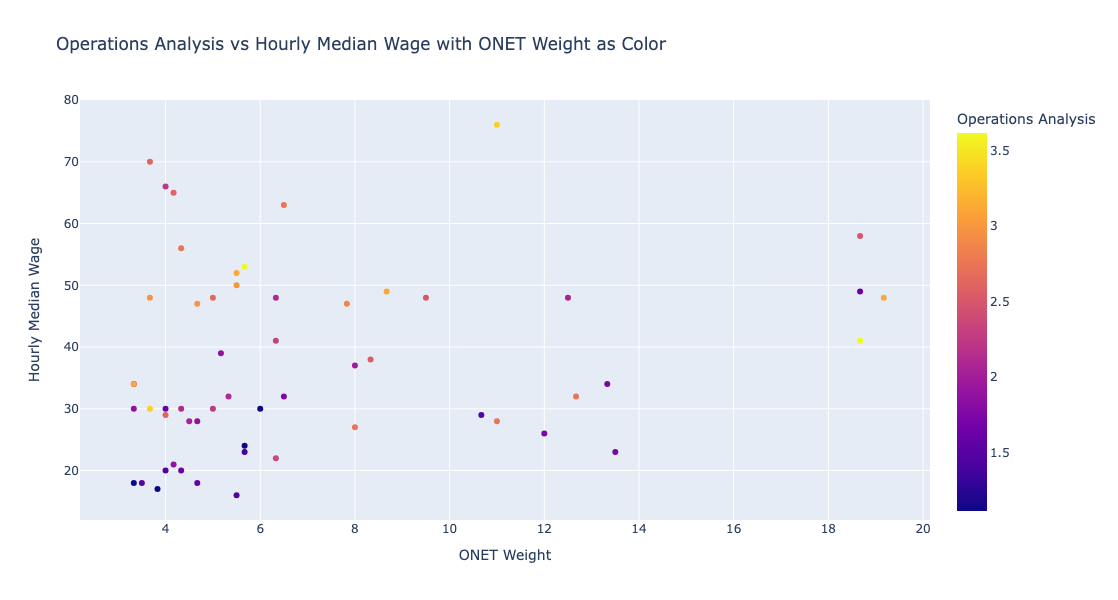

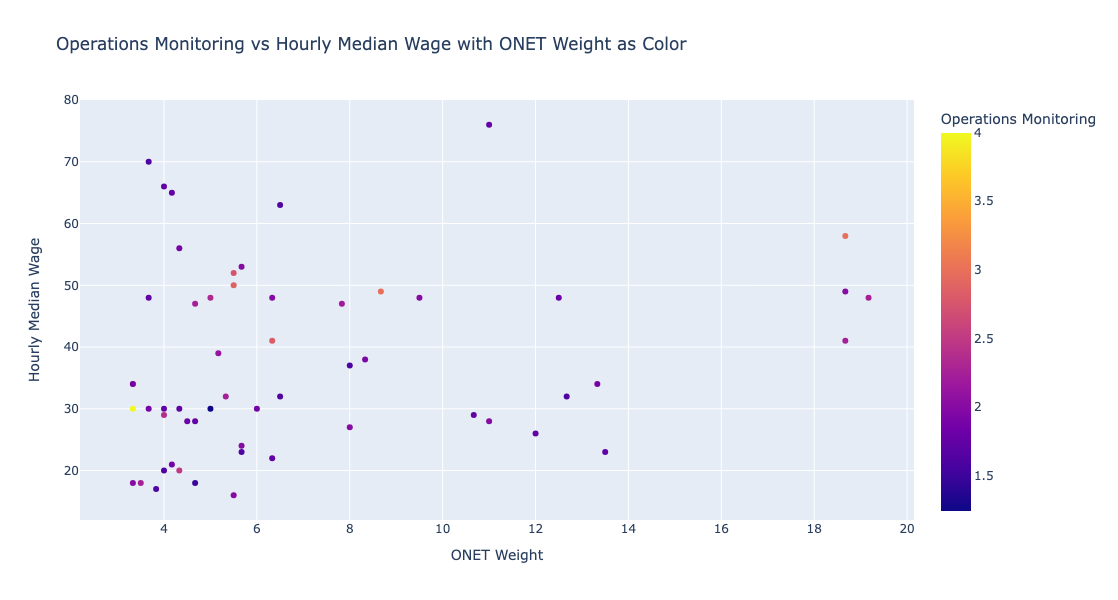

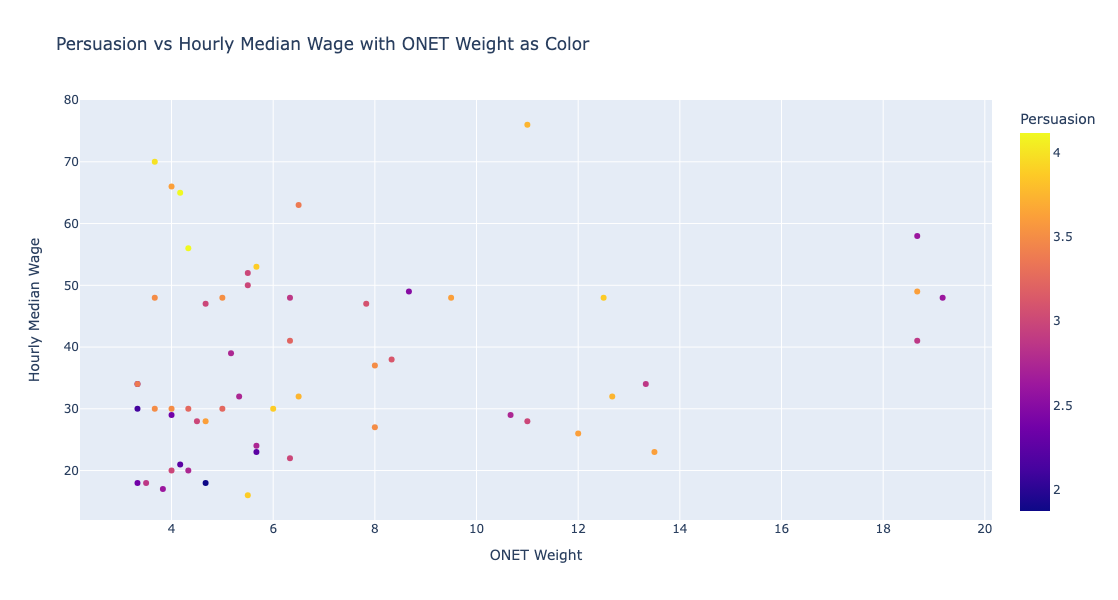

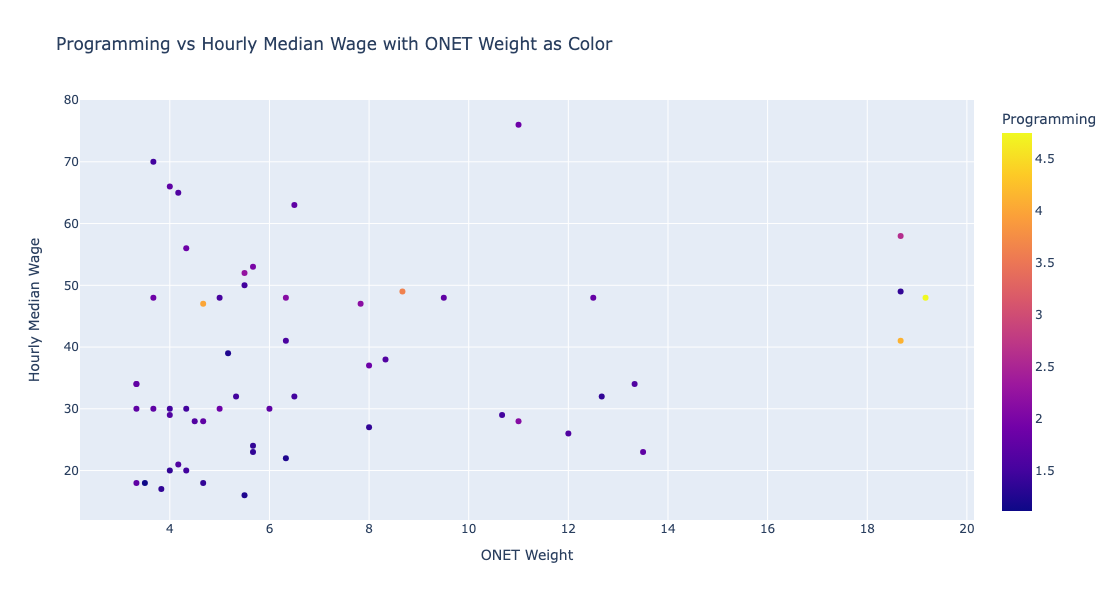

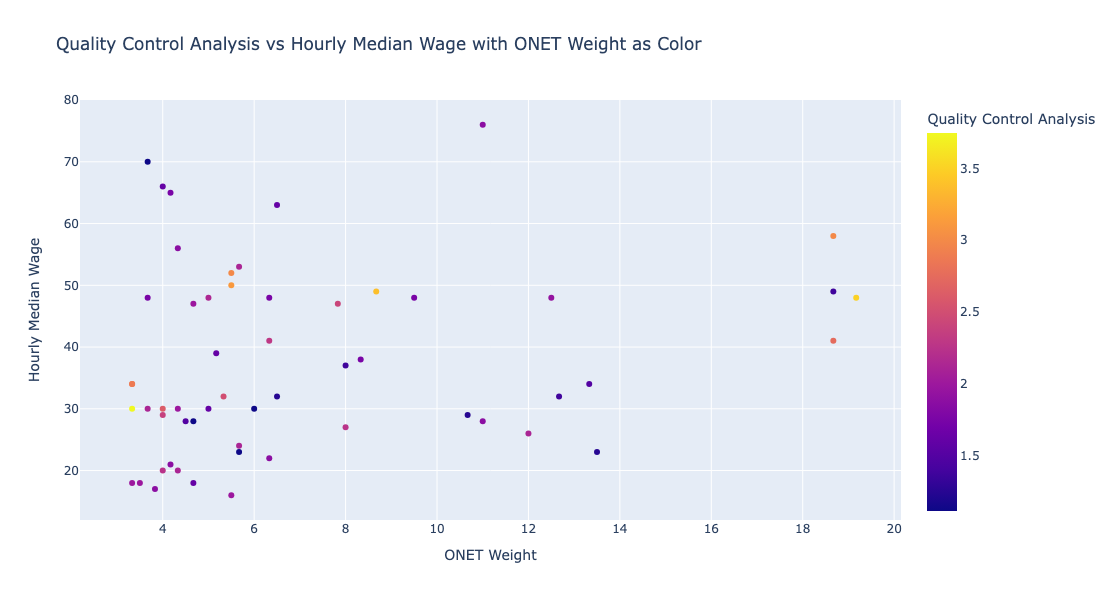

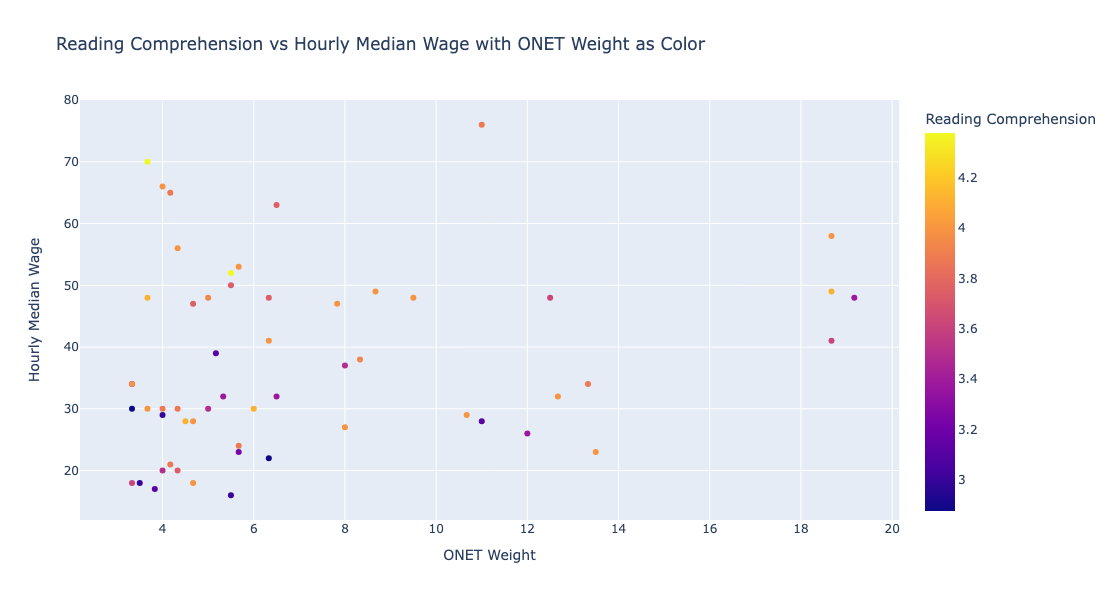

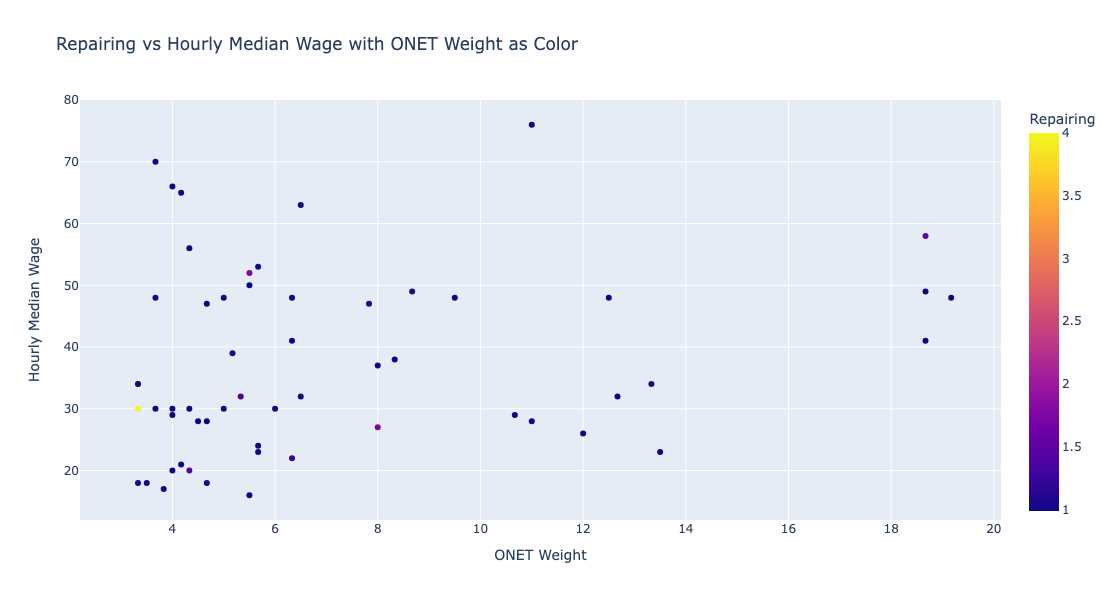

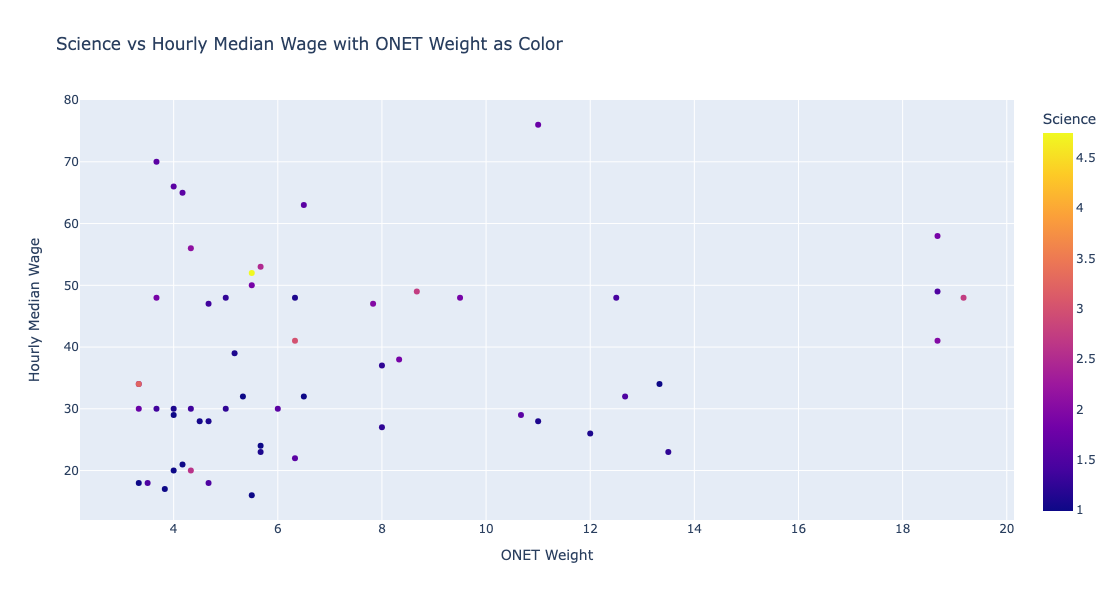

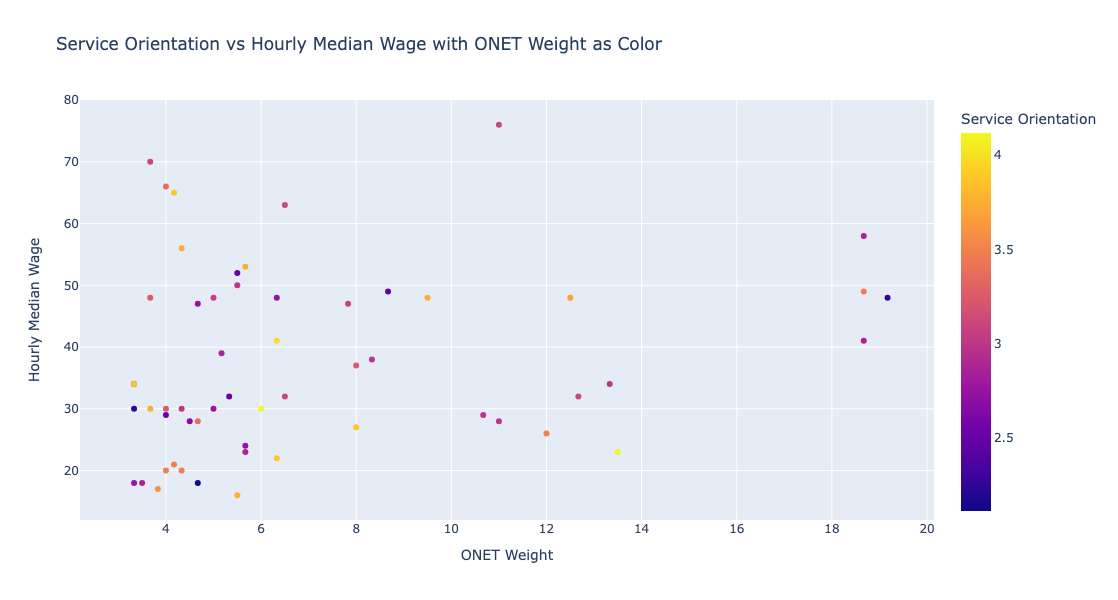

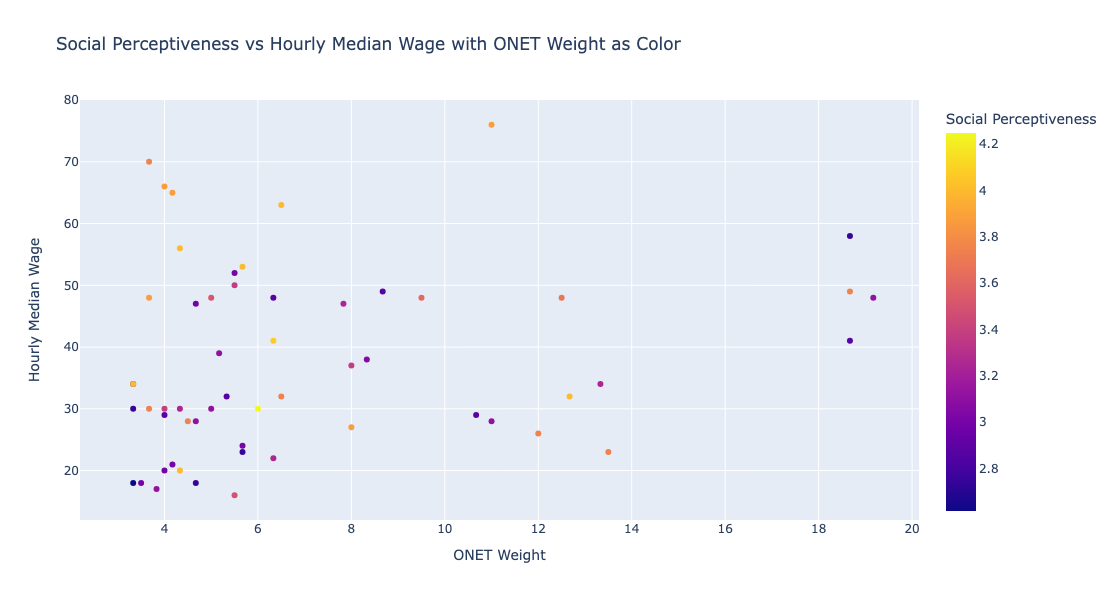

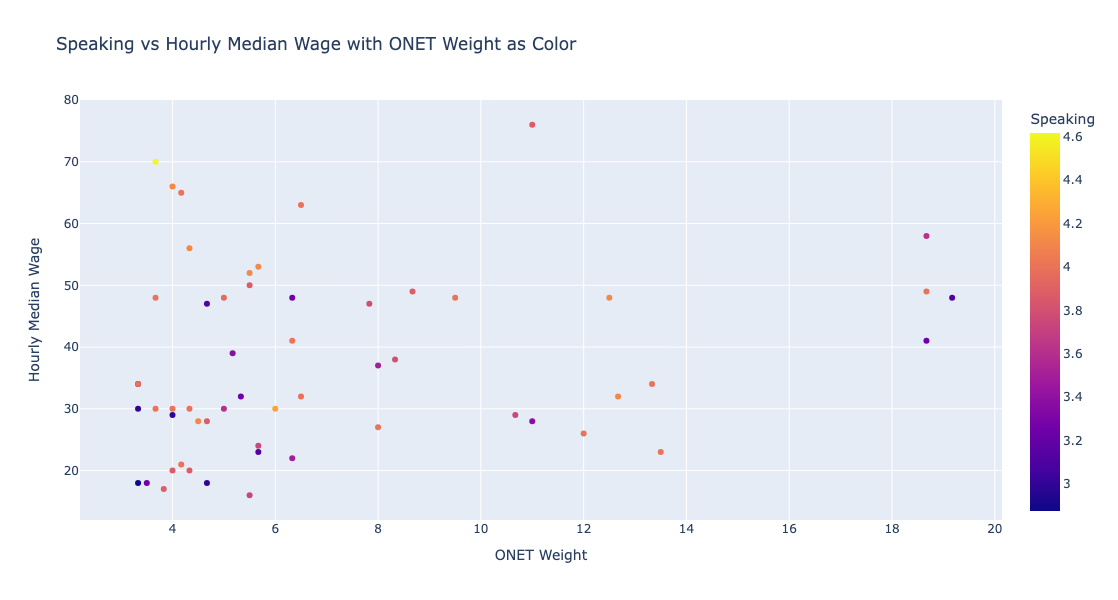

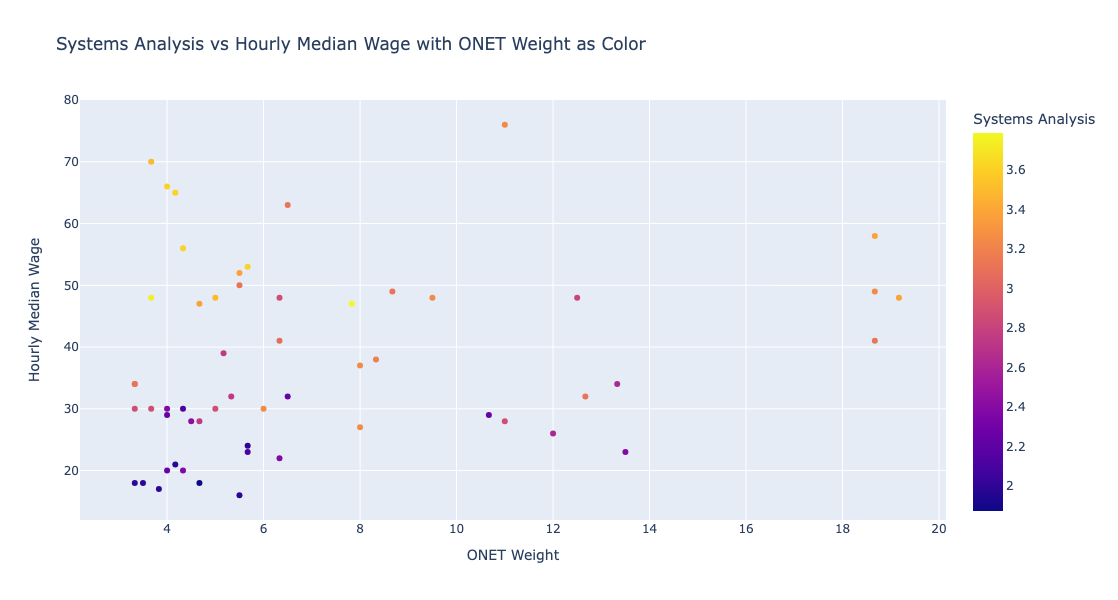

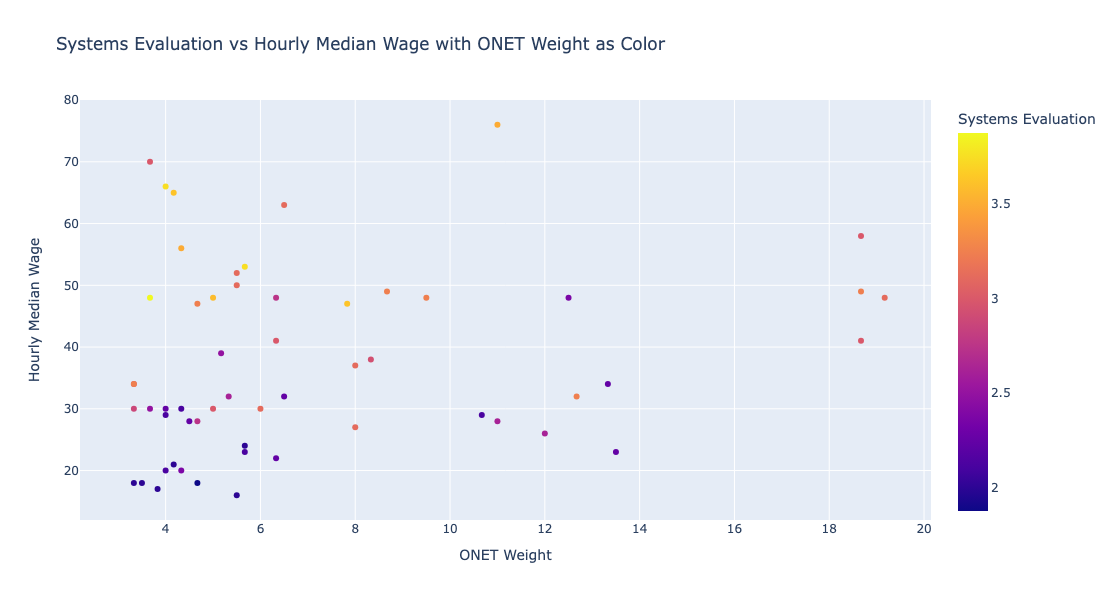

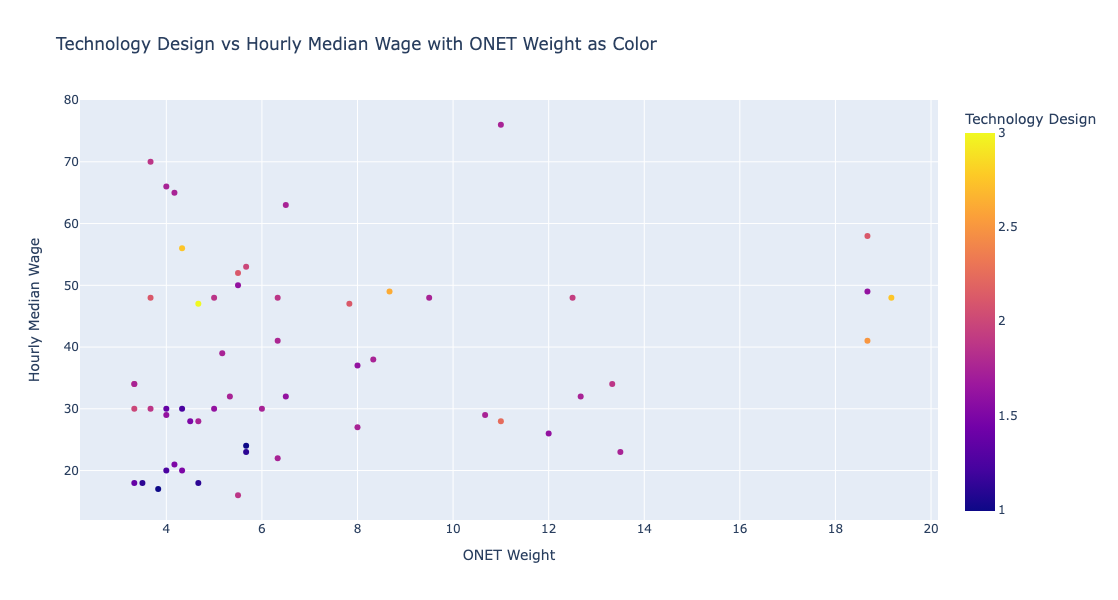

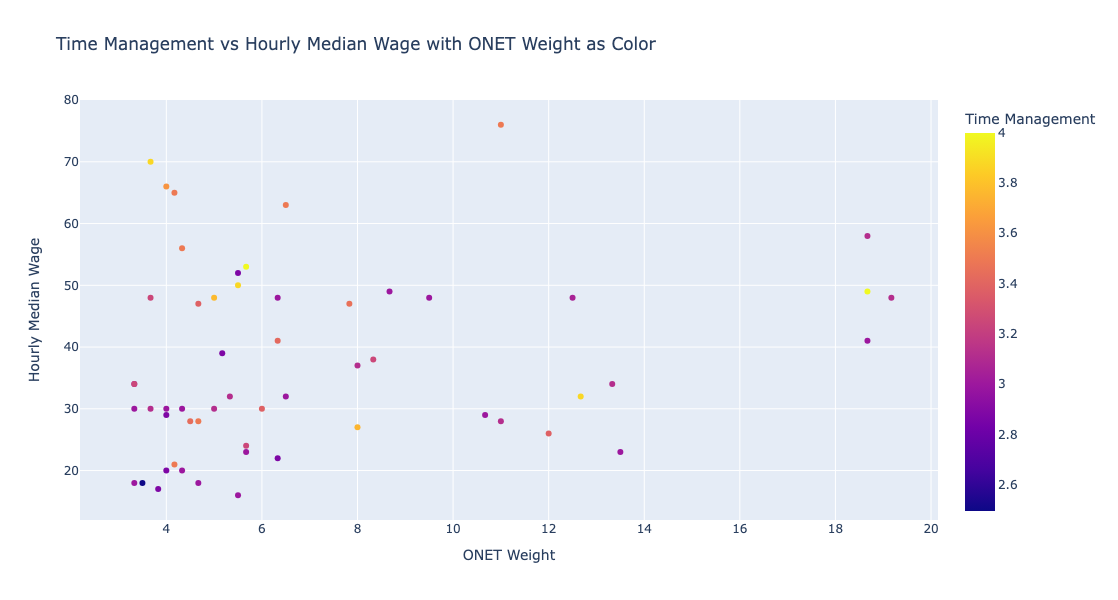

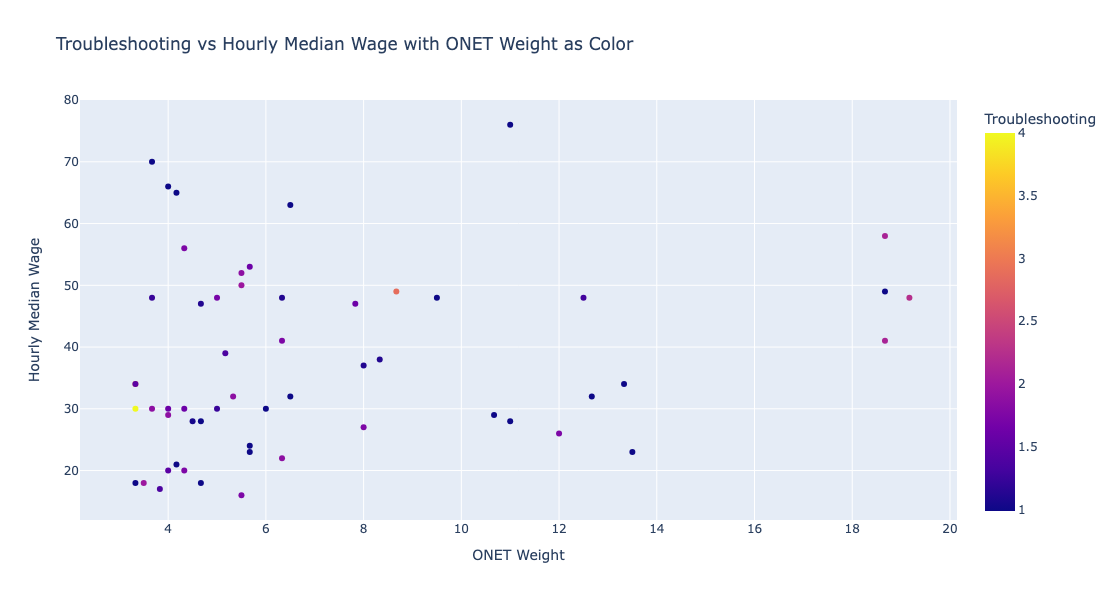

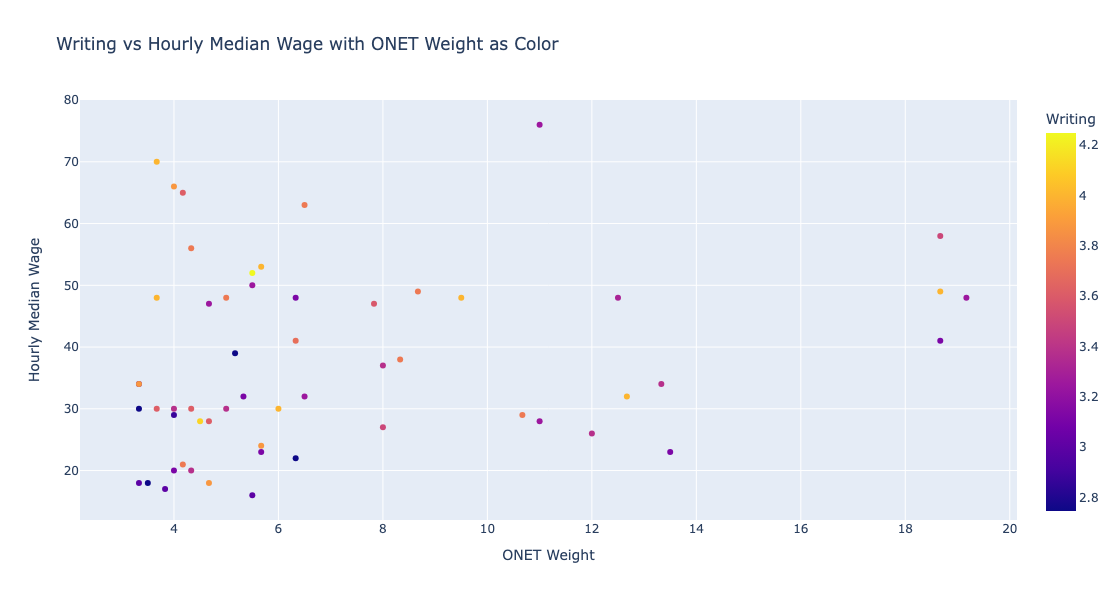

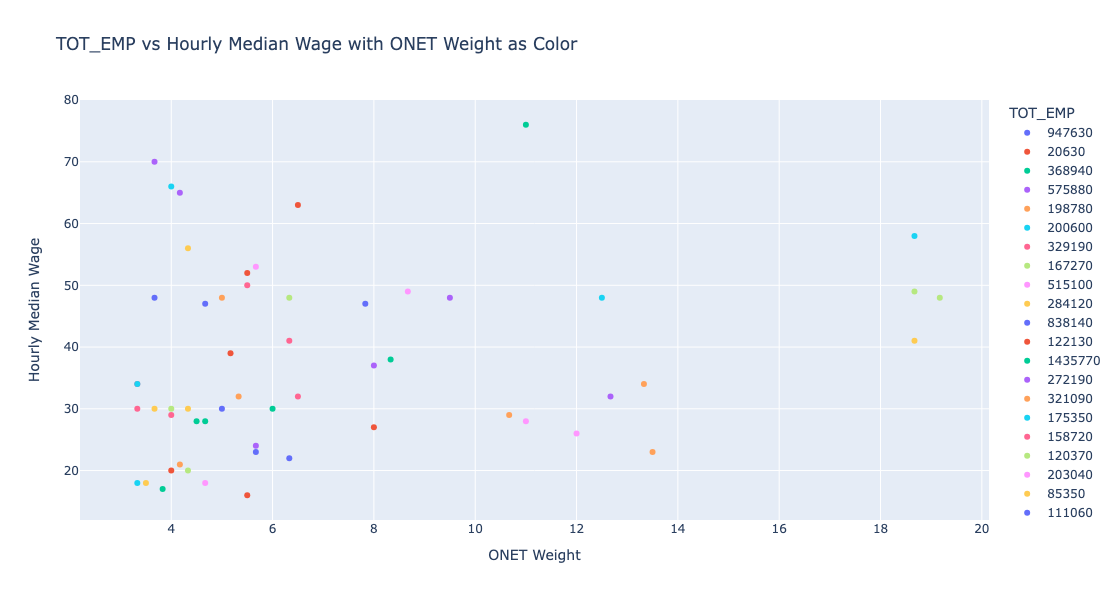

In [292]:
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D  # for 3D plotting
import plotly.express as px
bls_titles = bls_titles[(bls_titles["onet_weight"]<20) & (bls_titles["onet_weight"]>3)]
types = ['Active Learning', 'Active Listening',
       'Complex Problem Solving', 'Coordination', 'Critical Thinking',
       'Equipment Maintenance', 'Equipment Selection', 'Installation',
       'Instructing', 'Judgment and Decision Making', 'Learning Strategies',
       'Management of Financial Resources', 'Management of Material Resources',
       'Management of Personnel Resources', 'Mathematics', 'Monitoring',
       'Negotiation', 'Operation and Control', 'Operations Analysis',
       'Operations Monitoring', 'Persuasion', 'Programming',
       'Quality Control Analysis', 'Reading Comprehension', 'Repairing',
       'Science', 'Service Orientation', 'Social Perceptiveness', 'Speaking',
       'Systems Analysis', 'Systems Evaluation', 'Technology Design',
       'Time Management', 'Troubleshooting', 'Writing', 'TOT_EMP']

# #make the label when you go over it to be the onet_title
# for type in types:
#     plt.figure(figsize=(14, 10))
#     scatter = plt.scatter(x=bls_df['onet_weight'], y=bls_df['H_MEDIAN'], c=bls_df[type], cmap='viridis', alpha=0.7)
#     plt.xlabel('ONET WEIGHT')
#     plt.ylabel('Hourly Median Wage (H_MEDIAN)')
#     plt.title(f'{type} vs Hourly Median Wage with ONET Weight as Color')
#     plt.colorbar(scatter, label=type)
#     plt.show()

for type in types:
    fig = px.scatter(
        bls_titles,
        x='onet_weight',
        y='H_MEDIAN',
        color=type,
        labels={
            'onet_weight': 'ONET Weight',
            'H_MEDIAN': 'Hourly Median Wage',
            type: type
        },
        hover_name='onet_title',
        title=f'{type} vs Hourly Median Wage with ONET Weight as Color'
    )
    fig.update_layout(
        coloraxis_colorbar=dict(title=type),
        autosize=False,
        width=800,
        height=600
    )
    fig.show()

In [297]:
list(df.onet_task)

['Edit video for broadcast productions, including non-linear editing.',
 'Edit video for broadcast productions, including non-linear editing.',
 'Edit video for broadcast productions, including non-linear editing.',
 'Program computerized graphic effects.',
 'Set up and operate computer editing systems, electronic titling systems, video switching equipment, and digital video effects units to produce a final product.',
 'Program computerized graphic effects.',
 'Edit films and videotapes to insert music, dialogue, and sound effects, to arrange films into sequences, and to correct errors, using editing equipment.',
 'Program computerized graphic effects.',
 'Edit films and videotapes to insert music, dialogue, and sound effects, to arrange films into sequences, and to correct errors, using editing equipment.',
 'Organize and string together raw footage into a continuous whole according to scripts or the instructions of directors and producers.',
 'Edit films and videotapes to insert musi

In [298]:
list(df.columns)

['organization name',
 'founded date',
 'website',
 'description_all',
 'industries_parsed',
 'generated_description',
 'parsed_description',
 'Tasks/Jobs',
 'Industry',
 'Customers',
 'generated_description_conf_interval',
 'parsed_description_conf_interval',
 'organization_name',
 'example',
 'situation_conf_interval',
 'situation_conf_interval_reasoning',
 'job',
 'onet_title',
 'onet_task',
 'example_job_title',
 'task_similarity',
 'job_title_similarity',
 'Job_similarity_titles',
 'onet_weight',
 'Major Group_x',
 'Minor Group_x',
 'Broad Group_x',
 'Detailed Occupation',
 'Title_x',
 'Major Group Name_x',
 'Minor Group Name_x',
 'Broad Group Name_x',
 'similar_title_groups',
 'title_overlap',
 'title_groups',
 'broad_occ',
 'Major Group_y',
 'Minor Group_y',
 'Broad Group_y',
 'Title_y',
 'Major Group Name_y',
 'Minor Group Name_y',
 'Broad Group Name_y',
 'Active Learning',
 'Active Listening',
 'Complex Problem Solving',
 'Coordination',
 'Critical Thinking',
 'Equipment Maint

In [46]:
sample_df = pd.read_csv('../output/results v3/df_with_examples_embeddings.csv')
sample_df.head()

organization name                                   full_description  \
0              Pika  Pika is a startup that is developing an AI-pow...   
1     Contextual AI  Contextual AI offers a pioneering approach to ...   
2            Sierra  Sierra is an AI startup that tackles essential...   
3      Essential AI  Essential AI creates AI solutions that enhance...   
4         Liquid AI  Liquid AI is a developer of AI applications th...   

                                          industries  \
0  Artificial Intelligence (AI), Generative AI, G...   
1  Artificial Intelligence (AI), Generative AI, S...   
2  Artificial Intelligence (AI), Enterprise Softw...   
3  Artificial Intelligence (AI), Information Tech...   
4  Artificial Intelligence (AI), Generative AI, I...   

                      headquarters location founded date  \
0      Palo Alto, California, United States   2023-01-01   
1  Mountain View, California, United States   2023-01-01   
2  San Francisco, California, United States   2023-01-01   
3  San Francisco, California, United States   2023-01-01   
4   Cambridge, Massachusetts, United States   2023-01-01   

                                         description CB rank  \
0  Pika is a startup that develops an AI-powered ...      71   
1  Contextual AI offers a pioneering approach to ...     217   
2  Sierra is an AI startup that tackles essential...     273   
3  Essential AI creates AI solutions that enhance...     287   
4  Liquid AI is a developer of AI applications th...     544   

                                 headquarters region postal code  \
0  San Francisco Bay Area, Silicon Valley, West C...       94301   
1  San Francisco Bay Area, Silicon Valley, West C...       94040   
2     San Francisco Bay Area, West Coast, Western US           —   
3     San Francisco Bay Area, West Coast, Western US           —   
4       Greater Boston Area, East Coast, New England       02142   

  estimated revenue  ...                                               Job3  \
0                 —  ...  Graphic Designers that develop or create visua...   
1                 —  ...  Sales Representatives that analyze sales data ...   
2                 —  ...  Market Research Analysts that collect and anal...   
3                 —  ...  Customer Service Representatives that answer q...   
4       $1M to $10M  ...  Photographers that organize and catalog photog...   

                         Job3_title situation3_conf_interval  \
0                 Graphic Designers                        6   
1             Sales Representatives                        7   
2          Market Research Analysts                        8   
3  Customer Service Representatives                        7   
4                     Photographers                        9   

                  situation3_conf_interval_reasoning  \
0  This example relies on creating visuals and an...   
1  This example uses the product for analyzing da...   
2  AI agents are well-suited for gathering and an...   
3  While not explicitly mentioned in ONET tasks, ...   
4  While photographers already organize and tag t...   

                                      Job1_embedding  \
0  [-0.02056259848177433, 0.0018024604069069028, ...   
1  [-0.01855560392141342, -0.015776019543409348, ...   
2  [-0.010827294550836086, -0.031098157167434692,...   
3  [0.002181823132559657, -0.020050395280122757, ...   
4  [-0.0007555852644145489, -0.013203986920416355...   

                                Job1_title_embedding  \
0  [-0.010347506031394005, 0.0012261056108400226,...   
1  [-0.005443828646093607, -0.015293067321181297,...   
2  [0.0009003912564367056, -0.03677786514163017, ...   
3  [0.01442556083202362, -0.027022844180464745, -...   
4  [0.013557185418903828, 0.014009915292263031, -...   

                                      Job2_embedding  \
0  [-0.008843064308166504, 0.0004661160637624562,...   
1  [0.012479855678975582, -0.02793855406343937, -...   
2  [-0.012614410370588303,

In [47]:

melted_examples = pd.melt(sample_df, id_vars=['organization name'], value_vars=['Example1', 'Example2', 'Example3'], 
                    var_name='number', value_name='Example')

melted_jobs = pd.melt(sample_df, id_vars=['organization name'], value_vars=['Job1_embedding', 'Job2_embedding', 'Job3_embedding'], 
                      var_name='number', value_name='task_embedding')
melted_jobs.number = melted_jobs.number.apply(lambda x: x[3])
melted_examples.number = melted_examples.number.apply(lambda x: x[-1])


embedding_df = pd.merge(melted_examples, melted_jobs, on=['organization name', 'number'])

In [48]:
task_embeddings = []
for x in embedding_df.task_embedding:
    task_embeddings.append([float(y) for y in x.strip("[]").split(", ")])
embedding_df.task_embedding = task_embeddings

In [51]:
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt
# import seaborn as sns
# from mpl_toolkits.mplot3d import Axes3D  # for 3D plotting
# import plotly.express as px

# # Assuming 'sample_df' contains a column 'openai_embedding_entire' with appropriate data
# embeddings = np.vstack(embedding_df['task_embedding'].values)[:1000]

# # Apply t-SNE to the embeddings with 3 components for 3D visualization
# tsne = TSNE(n_components=3, perplexity=100, n_iter=1000)
# tsne_results = tsne.fit_transform(embeddings)




In [52]:
df = embedding_df.merge(df,left_on=["organization name","Example"],right_on=["organization name","example"])

In [53]:
df.groupby("Major Group_y")["organization_name"].count().sort_values()

Major Group_y
37-0000      2
35-0000      2
47-0000      3
51-0000      4
53-0000      6
33-0000      7
45-0000      9
49-0000     17
39-0000     18
21-0000     25
31-0000     32
23-0000     33
25-0000     35
17-0000     36
19-0000     47
29-0000     50
41-0000    201
27-0000    238
43-0000    293
11-0000    343
15-0000    600
13-0000    625
Name: organization_name, dtype: int64

In [54]:
graph_df = df[df["Major Group_y"]=="13-0000"]
graph_df.head()

organization name number  \
13        Sixfold AI      1   
14        Sixfold AI      1   
25             Genmo      1   
32          Worth AI      1   
33         Greenlite      1   

                                              Example  \
13  An insurance underwriter utilizes Sixfold AI t...   
14  An insurance underwriter utilizes Sixfold AI t...   
25  A marketing team uses Genmo to create short, e...   
32  A loan officer at a bank uses Worth AI to auto...   
33  A compliance analyst at a fintech company uses...   

                                       task_embedding founded date  \
13  [-0.020719492807984352, -0.009365797974169254,...   2023-01-01   
14  [-0.020719492807984352, -0.009365797974169254,...   2023-01-01   
25  [-0.0005672050756402314, -0.029202835634350777...   2023-01-01   
32  [-0.042917631566524506, -0.016369717195630074,...   2023-01-01   
33  [-0.05021313950419426, 0.0033216597512364388, ...   2023-01-01   

             website                                    description_all  \
13    www.sixfold.ai  Sixfold AI is an insurtech startup that levera...   
14    www.sixfold.ai  Sixfold AI is an insurtech startup that levera...   
25     www.genmo.ai/  Genmo is an artificial intelligence creative c...   
32      worthai.com/  Worth AI AI platform help businesses underwrit...   
33  www.greenlite.ai  Greenlite streamlines fintech and banking comp...   

                                    industries_parsed  \
13  ['Generative AI', 'InsurTech', 'Productivity T...   
14  ['Generative AI', 'InsurTech', 'Productivity T...   
25               ['Content', 'Digital Entertainment']   
32  ['Business Intelligence', 'FinTech', 'Risk Man...   
33     ['Augmented Reality', 'Compliance', 'FinTech']   

                                generated_description  \
13  Sixfold AI is an insurtech company using gener...   
14  Sixfold AI is an insurtech company using gener...   
25  Genmo is an AI-powered platform that helps use...   
32  Worth AI is an AI platform that streamlines un...   
33  Greenlite is an AI-powered platform that autom...   

                                   parsed_description  ... H_MEDIAN H_PCT75  \
13  Tasks/Jobs: Risk assessment, Policy generation...  ...     37.0   49.04   
14  Tasks/Jobs: Risk assessment, Policy generation...  ...     36.0   43.80   
25  Tasks/Jobs: Video generation, Image generation...  ...     36.0   49.26   
32  Tasks/Jobs: Risk assessment, Underwriting, Onb...  ...     34.0   48.09   
33  Tasks/Jobs: Screening alert handling, Business...  ...     48.0   62.49   

   H_PCT90  A_PCT10 A_PCT25 A_MEDIAN A_PCT75  A_PCT90 ANNUAL HOURLY  
13   63.47    48480   61370  77860.0  102000   132010    NaN    NaN  
14   50.69    47390   58770  75050.0   91100   105440    NaN    NaN  
25   65.89    40040   52840  74680.0  102450   137040    NaN    NaN  
32   67.05    37020   49130  69990.0  100020   139470    NaN    NaN  
33   84.54    60830   76880  99010.0  129970   175840    NaN    NaN  

[5 rows x 112 columns]

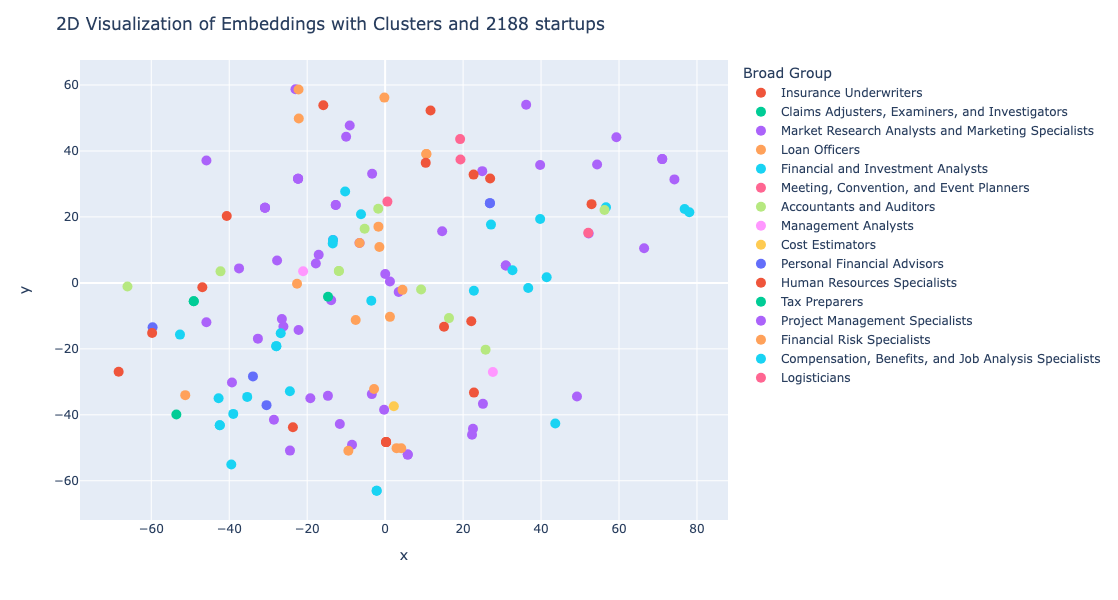

In [36]:
# Assuming 'sample_df' contains a column 'openai_embedding_entire' with appropriate data
embeddings = np.vstack(graph_df['task_embedding'].values)[0:]
tsne = TSNE(n_components=3, perplexity=100, n_iter=1000)
tsne_results = tsne.fit_transform(embeddings)

# Prepare DataFrame for Plotly
plot_df = pd.DataFrame(tsne_results[:, [0,1]], columns=['x', 'y'])
plot_df['Broad Group'] = graph_df["Title_y"][0:]
plot_df['onet_task'] = graph_df["onet_task"][0:]
# Plot using Plotly with clusters
fig = px.scatter(plot_df, x='x', y='y',
                 color='Broad Group',
                 color_continuous_scale=px.colors.diverging.Tealrose,
                 hover_data=['onet_task'])
fig.update_traces(marker_size=10)
fig.update_layout(
    title=f"2D Visualization of Embeddings with Clusters and {len(sample_df)} startups", 
    hovermode='closest',
    width=1000,  # Set the width of the figure
    height=600  # Set the height of the figure
)
fig.show()

In [18]:
list(df.columns)

['organization name',
 'number',
 'Example',
 'task_embedding',
 'founded date',
 'website',
 'description_all',
 'industries_parsed',
 'generated_description',
 'parsed_description',
 'Tasks/Jobs',
 'Industry',
 'Customers',
 'generated_description_conf_interval',
 'parsed_description_conf_interval',
 'organization_name',
 'example',
 'situation_conf_interval',
 'situation_conf_interval_reasoning',
 'job',
 'onet_title',
 'onet_task',
 'example_job_title',
 'task_similarity',
 'job_title_similarity',
 'Job_similarity_titles',
 'onet_weight',
 'Major Group_x',
 'Minor Group_x',
 'Broad Group_x',
 'Detailed Occupation',
 'Title_x',
 'Major Group Name_x',
 'Minor Group Name_x',
 'Broad Group Name_x',
 'similar_title_groups',
 'title_overlap',
 'title_groups',
 'broad_occ',
 'Major Group_y',
 'Minor Group_y',
 'Broad Group_y',
 'Title_y',
 'Major Group Name_y',
 'Minor Group Name_y',
 'Broad Group Name_y',
 'Active Learning',
 'Active Listening',
 'Complex Problem Solving',
 'Coordination

In [40]:
list(df.onet_task)

['Edit video for broadcast productions, including non-linear editing.',
 'Program computerized graphic effects.',
 'Confer with customers by telephone or in person to provide information about products or services, take or enter orders, cancel accounts, or obtain details of complaints.',
 'Write press releases or other media communications to promote clients.',
 'Use computer software to generate new images.',
 'Draw and print charts, graphs, illustrations, and other artwork, using computer.',
 'Schedule and make appointments.',
 'Schedule and confirm appointments for clients, customers, or supervisors.',
 'Arrange conference, meeting, or travel reservations for office personnel.',
 'Identify relationships and trends or any factors that could affect the results of research.',
 'Identify relationships and trends in data, as well as any factors that could affect the results of research.',
 'Prepare, proofread, or process legal documents, such as summonses, subpoenas, complaints, appeals,

In [14]:
# e1 = x_chat.get_embedding(s1)
#e1 = df_exp[df_exp.description.str.contains("managers that evaluate the organization")].task_embedding.iloc[0]
s2 = "Analyzing Data or Information"
e2 = x_chat.get_embedding(s2)
# e1 = df.task_embedding[1]
s1 = "Resolve problems concerning transportation, logistics systems, imports or exports, or customer issues."
e1 = x_chat.get_embedding(s1)

In [15]:
e1 = np.array(e1).reshape(1,-1)
e2 = np.array(e2).reshape(1,-1)
cosine_similarity(e1,e2, 'cosine')[0][0]

0.22837435659752314